# Recover axisymmetric kinematics model from projected imaging info for a sample of lens galaxies, with different inclination angle prior, and triaxial ellipticity

Xiangyu Huang, 2024, Stony Brook

In this notebook, we want to test the kinematics recovery for intrinsically axisymmetric galaxies. We generate the projected MGE with axisymmetric luminosity and density profiles. In the kinematics recovery, we consider the case when the luminosity profile is actually triaxial rather than axisymmetric, i.e. the luminosity profile has two intrinsic axis ratios and have different projected ellipticity than the density profile. We want to test whether this would bias the recovered velocity dispersion. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from copy import deepcopy
import h5py

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)
import matplotlib.patches as patches


In [2]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

from deproject.Util.orientation import Isotropic_inclination
from deproject.Util.ellipticity import Axis_ratio2ellipticity, Ellipticity2axis_ratio 
from deproject.projection import Projection
from deproject.projection_axisymmetric import Projection_axisym
from deproject.Util.random_var import Draw_from_pdf
from deproject.Cosmo.default_cosmo import get_default_lens_cosmo

from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from get_sigma_e import get_sigma_e

## Calculate the triaxial ellipticity of the lens galaxy with the inclination angle in the mock data

In [3]:
oblate = True

if oblate:
    oblate_name = 'oblate'
else:
    oblate_name = 'prolate'

In [4]:
rerun_calculation = True

# load previously saved data
if not rerun_calculation:
    data = np.load('./triaxial_ellipticity_{}.npy' .format(oblate_name))
    inc_tri_all, eobs_tri_all, vel_disp_tri_all = data

    if oblate:
        Qobs_tri_all = Ellipticity2axis_ratio(eobs_tri_all)
    else:
        Qobs_tri_all = 1/Ellipticity2axis_ratio(eobs_tri_all)


(650,)


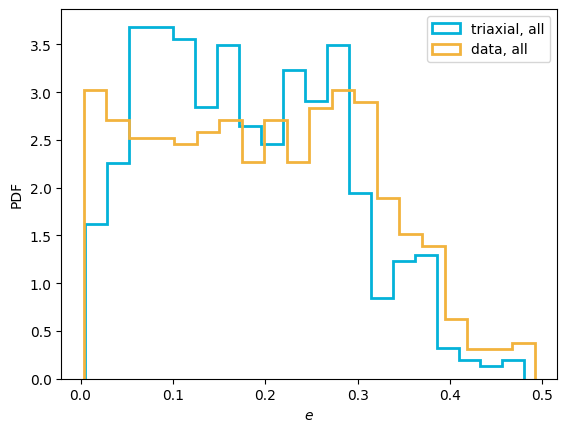

In [5]:
data = np.load('./tng_kin_{}.npy' .format(oblate_name))
data_copy = deepcopy(data)

qobs_data = data_copy[1, :]
theta_e_data = data_copy[0, :]
inc_data = data_copy[3, :]
sigma_e_data = data_copy[2, :]
if oblate:
    eobs_data = Axis_ratio2ellipticity(qobs_data)
else:
    eobs_data = -1 * Axis_ratio2ellipticity(qobs_data)
print(eobs_data.shape)


# read catalog for the intrinsic axis ratio
cat = pd.read_pickle('./axisym_tng_catalog/{}_catalog.pkl' .format(oblate_name))
zeta =  cat['zeta'].values
xi = cat['xi'].values
zeta = np.repeat(zeta, 10)
xi = np.repeat(xi, 10)

if rerun_calculation:
    # reconstruct the projected ellipticity, assuming the galaxies are triaxial
    theta_all, phi_all = data[4:] 

    projection = Projection(zeta=zeta, xi=xi, phi=phi_all, theta=theta_all)
    Qobs_tri_all = projection.AxisRatio()
    eobs_tri_all = Axis_ratio2ellipticity(Qobs_tri_all)

    if not oblate:
        Qobs_tri_all = 1/Qobs_tri_all


# plot the distribution of ellipticity
plt.figure()
plt.hist(eobs_tri_all, density=True, histtype='step', lw = 2, label = 'triaxial, all', bins=20)
plt.hist(eobs_data, density=True, histtype='step', lw = 2, label = 'data, all', bins=20)
plt.xlabel('$e$')
plt.ylabel('PDF')
plt.legend()
plt.show()

## Draw inclination angle for the given ellipticity distribution

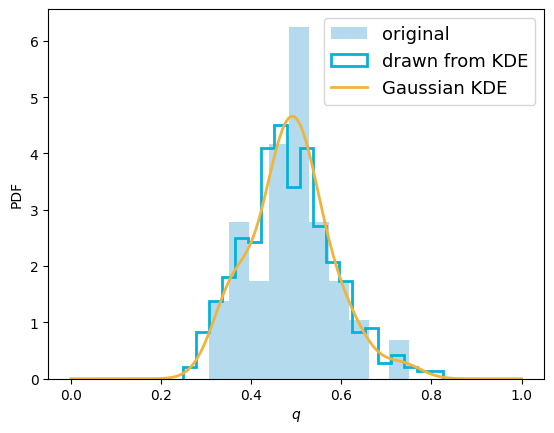

In [6]:
# read catalog for the intrinsic axis ratio
if oblate:
    qintr = cat['xi_new'].values
else:
    qintr = 1/cat['zeta_new'].values

kde = gaussian_kde(qintr)
if oblate:
    qintr_cdf = np.linspace(0, 1, 150)
    qintr_plot = np.linspace(0, 1, 150)
else:
    qintr_cdf = np.linspace(0, 3, 150)
    qintr_plot = np.linspace(0.5, 3, 150)

qintr_kde = kde(qintr_cdf)
qintr_rm = Draw_from_pdf(qintr_cdf, qintr_kde, 500, bins_hist=15)

plt.figure()
plt.hist(qintr, color = clist[4], density=True, bins=10, alpha = 0.3, label='original')
plt.hist(qintr_rm, histtype='step', lw = 2, density=True, label='drawn from KDE', bins = 20)
plt.plot(qintr_plot, kde(qintr_plot), lw = 2, marker = ' ', label = 'Gaussian KDE')
plt.xlabel('$q$')
plt.ylabel('PDF')
plt.legend(loc='best', prop = {'size': 13})
plt.show()

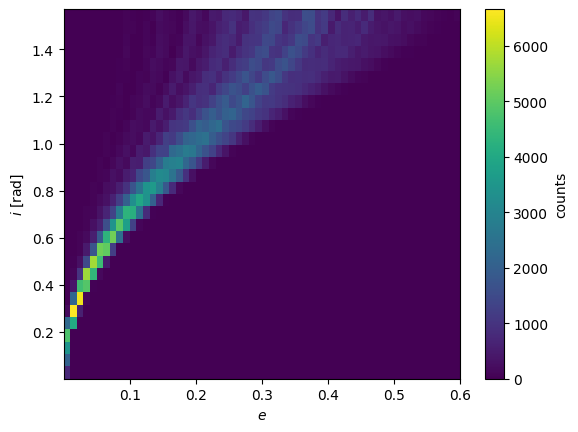

In [7]:
projection_axisym = Projection_axisym(qintr_rm)

projection_axisym.Eobs_dist_iso_inc(plot_scatter=0, plot_2dhist=1, single_proj=1000, bins_2dhist_plot=[60, 30]) # test 
plt.show()

In [8]:
# testing drawing P(i|e) from the P(i, e) histogram
# kwargs_eobs_iso_inc = {'single_proj': 1000, 'plot_2dhist': 0, 'bins_2dhist_plot': [30, 30], 'plot_scatter': 0}
# projection_axisym.Cond_pdf_inc_given_eobs(0.2, plot_1dpdf=1, bins_2dhist=[40, 30], normalize=0, **kwargs_eobs_iso_inc, quiet=1) # test

### Recovered inclination angle for the triaxial sample

#### No lensing selection

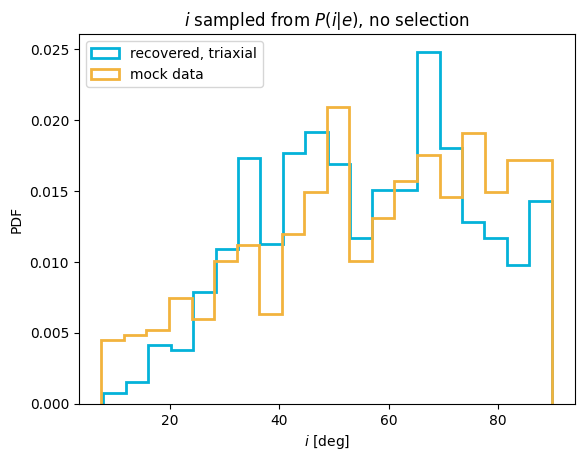

In [9]:
if rerun_calculation:
    inc_tri_all = projection_axisym.Recover_inclination(eobs_tri_all, bins_2dhist=[60, 30], qintr_min=0.05, single_proj=1000)

# if ellipcitity is out of range, then use 90 degrees
inc_tri_all = np.where(np.isfinite(inc_tri_all), inc_tri_all, np.pi/2)

plt.figure()
plt.hist(np.degrees(inc_tri_all), bins=20, label = 'recovered, triaxial', histtype='step', lw = 2, density=True)
plt.hist(inc_data, bins = 20, label = 'mock data', histtype='step', lw = 2, density=True)
plt.xlabel('$i$ [deg]')
plt.ylabel('PDF')
plt.title(r'$i$ sampled from $P(i|e)$, no selection')
plt.legend()
plt.show()

## Recover the kinematics with JAM

In [10]:
# access projected MGE.
with h5py.File('./tng_kin_mge_{}.hdf5' .format(oblate_name), 'r') as f:
    print(f.keys())
    peak_den = f['peak_den'][:]
    peak_lum = f['peak_lum'][:]
    sigma_den = f['sigma_den'][:]
    sigma_lum = f['sigma_lum'][:]


<KeysViewHDF5 ['peak_den', 'peak_lum', 'sigma_den', 'sigma_lum']>


### Modify the MGE according to the ellipticity to preserve mass and luminosity

When the ellipticity is changed from axisymmetric to triaxial, need to also modify the MGE such that the total mass and luminosity is preserved. In other words, the lens models are invariant. 

We change the shape of the mass/light profiles on the symmetry axis in projection. In MGE forms, the total luminosity is 
$$ 
L_k = 2 \pi \Sigma_{0k} \sigma_{k}^2 Q_k,
$$
where $\Sigma_{0k}$ and $\sigma_{k}$ are the amplitude and dispersion of the MGE, and $Q_k$ is the apparent axis ratio in projection. When we use instead the "triaxial" apparent axis ratio in projection $Q^t_k$, we change the dispersion of the MGE
$$
\sigma_k \rightarrow \sqrt{\frac{Q_k}{Q^t_k}} \sigma_k.
$$


In [11]:
coeff_all = np.sqrt(qobs_data / Qobs_tri_all)
coeff_all = coeff_all[:, None]
sigma_den_tri = coeff_all * sigma_den
sigma_lum_tri = coeff_all * sigma_lum


#### Run Jampy on the NO lensing selected triaxial sample

In [12]:
lens_cosmo = get_default_lens_cosmo()
distance = lens_cosmo.Dd

In [13]:
def recover_vel_disp(peak_lum, sigma_lum, qobs_lum, peak_den, sigma_den, qobs_den, inclination, distance):
    """recover velocoty dispersion given light and mass MGE

    Args:
        peak_lum (_type_): amplitude of the MGE describing the luminosity profile [L_sun/arcsec^2]
        sigma_lum (_type_): dispersion of the MGE describing the luminosity profile [arcsec]
        qobs_lum (_type_): axis ratio of the MGE describing the luminosity profile, for prolate, np.all(qobs_lum) > 1
        peak_den (_type_): amplitude of the MGE describing the density profile [M_sun/arcsec^2]
        sigma_den (_type_): dispersion of the MGE describing the density profile [arcsec]
        qobs_den (_type_): axis ratio of the MGE describing the density profile, for prolate, np.all(qobs_den) > 1
        inclination (_type_): inclination angle 
        distance (_type_): angular diameter distance to the system [Mpc]

    Returns:
        _type_: recovered velocity dispersion
    """
    vel_disp = np.zeros(len(peak_den))
    inc_deg = np.degrees(inclination)
    for i in range(len(peak_den)):
        peak_lum_i = peak_lum[i]
        sigma_lum_i = sigma_lum[i]
        peak_den_i = peak_den[i]
        sigma_den_i = sigma_den[i]
        qobs_lum_i = qobs_lum[i]
        qobs_den_i = qobs_den[i]
        beta = np.zeros_like(peak_lum_i) # isotropic anisotropy

        if qobs_lum_i > 1:
            qobs_lum_i_apparent = 1 / qobs_lum_i # for Q>1, take the inverse to calculate reff
        else:
            qobs_lum_i_apparent = qobs_lum_i

        # set up a grid to perform jam 
        reff = mge_half_light_isophote(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i_apparent))[0]
        xx = np.linspace(-2.5 * reff, 2.5 * reff, 100)  # avoid (x,y)=(0,0)
        xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

        # run jam
        jam = jam_axi_proj(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i), peak_den_i, sigma_den_i, np.full_like(peak_den_i, qobs_den_i), inc_deg[i], 0, distance, xbin, ybin, plot=0, beta=beta, align='sph')
        # compute sigma_e
        sigma_e = get_sigma_e(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i), jam, xbin, ybin)
        vel_disp[i] = sigma_e
        print(f"sigma_e: {sigma_e:.2f} km/s")

    return vel_disp

In [14]:
if rerun_calculation:
    vel_disp_tri_all = recover_vel_disp(peak_lum, sigma_lum_tri, Qobs_tri_all, peak_den, sigma_den_tri, Qobs_tri_all, inc_tri_all, distance)

mean_vel_disp_tri_all = np.mean(vel_disp_tri_all)

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 159.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 171.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 154.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 156.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.15
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 170.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 152.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.12
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 172.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 177.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 169.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.071e+13

sigma_e: 173.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 112.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 121.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 135.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 131.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 132.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 130.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 118.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 134.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 129.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.549e+12

sigma_e: 123.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 179.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 159.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 164.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 152.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 180.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 169.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 175.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 180.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 173.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.244e+13

sigma_e: 162.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.37
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 140.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 122.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 125.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 141.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 124.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 129.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 116.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 137.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 131.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.888e+12

sigma_e: 129.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.11
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 198.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 182.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 196.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 200.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 200.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 176.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 201.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 186.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 175.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.657e+13

sigma_e: 198.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 137.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 146.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 139.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=13.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 118.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 138.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 145.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 147.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 139.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 145.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.096e+13

sigma_e: 135.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 120.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 135.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 140.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.11
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 146.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 137.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 129.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 121.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 148.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 124.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.063e+13

sigma_e: 133.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 127.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 119.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 121.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 131.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 116.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 117.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 115.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=10.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 99.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 124.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.175e+12

sigma_e: 133.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 152.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 161.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 161.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 146.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 147.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 162.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 151.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 143.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 167.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.031e+13

sigma_e: 154.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 151.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 145.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 145.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 164.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 161.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 159.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 163.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 151.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 167.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.796e+13

sigma_e: 155.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 102.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 135.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 130.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 118.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 132.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 124.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 134.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 130.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 117.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.727e+12

sigma_e: 132.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 200.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 200.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 197.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 200.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 212.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 184.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 195.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 218.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 215.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e: 182.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 136.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 132.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 122.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 121.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 135.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 133.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 136.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 130.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 128.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.811e+12

sigma_e: 135.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 188.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 185.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 187.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 170.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 193.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 192.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 193.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 192.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 181.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.238e+13

sigma_e: 191.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 259.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 288.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 248.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=19.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 243.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 280.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 287.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 282.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 241.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 259.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=13.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.509e+14

sigma_e: 216.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.18
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 151.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 131.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 153.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 151.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 131.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 154.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 137.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 147.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 155.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.474e+13

sigma_e: 146.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 187.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 183.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 182.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 177.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 180.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 175.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 167.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 139.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 186.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.893e+13

sigma_e: 189.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 134.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 122.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 117.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 114.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 116.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 112.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 131.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 113.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 117.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.15
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.739e+12

sigma_e: 133.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 155.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 164.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 177.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 150.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 181.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 181.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 180.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 163.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 148.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.252e+13

sigma_e: 164.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 184.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 147.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 183.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 173.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 173.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.12
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 167.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 188.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 177.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 188.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+13

sigma_e: 173.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 113.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 131.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 113.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 129.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 114.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 111.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.98
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 126.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 130.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 120.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.831e+12

sigma_e: 108.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 213.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 226.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 225.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 217.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 211.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 213.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.17
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 222.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 213.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 197.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.084e+13

sigma_e: 202.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 157.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.98
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 169.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 169.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 150.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 166.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 158.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 153.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 168.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 169.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.737e+13

sigma_e: 156.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 204.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 178.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 187.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 188.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 196.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 196.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 173.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 188.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 203.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.725e+13

sigma_e: 193.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 127.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 107.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 131.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 130.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 121.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 134.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 130.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 126.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 131.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.905e+12

sigma_e: 128.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 189.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 185.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 167.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 191.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 190.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 191.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 171.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 184.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 185.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.984e+13

sigma_e: 192.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 137.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 138.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 140.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 130.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 146.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 114.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.11
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 144.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 146.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 135.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.062e+13

sigma_e: 146.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 199.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 199.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 177.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 195.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 201.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 196.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 178.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 187.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 170.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.624e+13

sigma_e: 174.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 190.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 186.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 187.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 178.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 196.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 191.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 183.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 190.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 200.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.810e+13

sigma_e: 189.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 142.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 154.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 153.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=16.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 127.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 132.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 149.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 160.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 152.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 138.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.643e+13

sigma_e: 161.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 150.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 145.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 153.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 150.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 131.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 139.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.11
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 119.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 139.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 141.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 144.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 153.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 167.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 178.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 158.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 166.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 153.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 165.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 165.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 171.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.384e+13

sigma_e: 176.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 154.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 151.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 149.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 145.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 155.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 154.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=23.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 130.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 152.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 147.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.240e+13

sigma_e: 137.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.14
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 120.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 143.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 135.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 159.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 148.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=23.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 136.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 148.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 160.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 154.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.442e+13

sigma_e: 146.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 135.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 132.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 130.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 130.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 125.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 124.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 122.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 130.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 122.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.410e+12

sigma_e: 133.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 172.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 163.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 169.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.12
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 174.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 172.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 165.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 158.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 172.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 174.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.946e+13

sigma_e: 131.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 165.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 167.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.11
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 165.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 139.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 166.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 161.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 151.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 160.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 158.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.676e+13

sigma_e: 151.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 129.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 140.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 127.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 137.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 125.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 142.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 128.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 142.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 142.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=23.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+12

sigma_e: 131.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 127.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 97.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.13
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 126.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 121.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 121.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 119.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 123.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 118.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 126.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.786e+12

sigma_e: 126.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 141.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 178.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.16
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 178.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 181.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 175.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 178.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 161.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 174.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 149.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.429e+13

sigma_e: 159.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 159.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 156.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 143.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 148.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 166.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 166.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=13.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 135.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 150.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 146.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+13

sigma_e: 166.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 135.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.12
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 151.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 135.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 152.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 134.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 150.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 146.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 135.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 138.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.168e+13

sigma_e: 145.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 160.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 154.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 142.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 159.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 149.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 160.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 137.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 145.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 159.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.437e+13

sigma_e: 159.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 146.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 140.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 144.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 130.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 135.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 140.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 143.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 138.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 145.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.021e+13

sigma_e: 133.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 166.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 138.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 162.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 164.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 154.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 162.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 149.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 155.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 141.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.689e+13

sigma_e: 165.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 147.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 167.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 159.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 163.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 174.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 165.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 175.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 151.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 173.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e: 166.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 124.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 128.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 140.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 141.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 143.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 126.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 125.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 126.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 142.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.11
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.783e+12

sigma_e: 125.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 147.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 148.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 135.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 128.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 144.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 130.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 144.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 150.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 137.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 128.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 135.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 134.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 123.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 129.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 131.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 124.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 127.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 128.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 128.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.097e+12

sigma_e: 136.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 116.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 119.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 131.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.98
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 114.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 134.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 126.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 126.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.98
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 121.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 118.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.812e+12

sigma_e: 127.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 139.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 104.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 110.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 141.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 142.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 143.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 129.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 143.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 140.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.704e+12

sigma_e: 141.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 130.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 139.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 140.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 138.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 115.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 134.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 115.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 134.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 125.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.414e+12

sigma_e: 123.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 144.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 142.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 141.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 136.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 132.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 142.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=7.93; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 94.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.12
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 144.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 141.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.005e+13

sigma_e: 142.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 133.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 136.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 147.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 139.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 150.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 137.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 142.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 141.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 143.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.082e+13

sigma_e: 133.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 151.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 160.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 153.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 140.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 142.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 133.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 147.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 149.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 143.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e: 158.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 127.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 114.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 118.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 130.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 135.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 137.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 135.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 119.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 116.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.905e+12

sigma_e: 122.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 125.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 132.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 134.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 112.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 126.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 113.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 111.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 111.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 127.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.920e+12

sigma_e: 119.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 120.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 134.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 128.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 115.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 128.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 124.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 124.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 132.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 129.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.168e+12

sigma_e: 133.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 140.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 140.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 148.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 149.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.99
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 140.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 145.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 144.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 147.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 133.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.205e+13

sigma_e: 148.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 120.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 137.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 130.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 135.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 140.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 139.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 122.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 131.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 129.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.973e+12

sigma_e: 139.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 133.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 112.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 129.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 118.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 127.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 133.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 128.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 127.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 118.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.013e+12

sigma_e: 129.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 136.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 152.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 157.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 157.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.21
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 156.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.10
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 148.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 156.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 154.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.08
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 156.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.371e+13

sigma_e: 140.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 119.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 118.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 141.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.06
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 125.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 136.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 116.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 131.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 124.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 131.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.128e+13

sigma_e: 116.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 180.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 165.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 180.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 172.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.09
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 177.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 179.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 178.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.04
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 184.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 159.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.397e+13

sigma_e: 172.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 127.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.07
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 136.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 153.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.02
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 137.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.12
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 144.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 145.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 153.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.05
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 154.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.00
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 130.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.03
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+13

sigma_e: 150.79 km/s


## save data

In [15]:
if rerun_calculation:
    data = np.array([inc_tri_all, eobs_tri_all, vel_disp_tri_all])
    np.save('./triaxial_ellipticity_{}.npy' .format(oblate_name), data)

    

##### Compare with axisymmetric sample with NO lensing selection

In [16]:
def percent_diff(a, b):
    return np.abs(a-b) / np.mean([a, b]) * 100

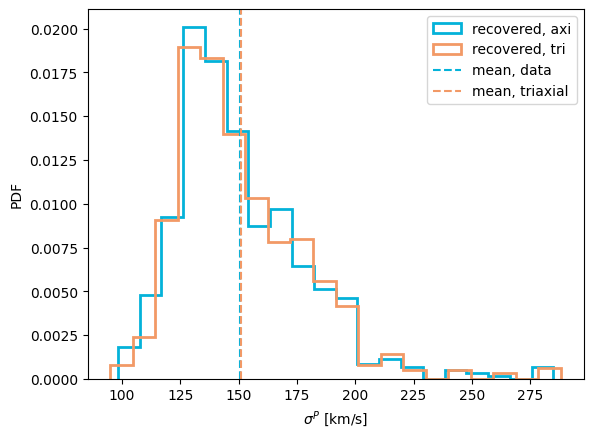

0.24734868083312625 %


In [17]:
mock_data = np.load('./tng_kin_{}.npy' .format(oblate_name))
vel_disp_axi_all = mock_data[2, :]

plt.figure()
plt.hist(vel_disp_axi_all, density=True, lw=2, histtype='step', label = 'recovered, axi', bins=20, color=clist[0])
# plt.hist(sigma_e_data, density=True, lw=2, histtype='step', label ='data', bins=20, color=clist[1])
plt.hist(vel_disp_tri_all, density=True, lw=2, histtype='step', label = 'recovered, tri', bins=20, color=clist[2])
plt.axvline(np.mean(vel_disp_axi_all), ls = '--', color = clist[0], marker = ' ', label = 'mean, data')
plt.axvline(mean_vel_disp_tri_all, ls = '--', color = clist[2], marker = ' ', label = 'mean, triaxial')
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('PDF')
plt.legend()
plt.show()

print(percent_diff(mean_vel_disp_tri_all, np.mean(sigma_e_data)), '%')

## Test deprojected mass distribution

In [18]:
def total_mass(peak_den, sigma_den, Qobs, distance):
    pc = distance*np.pi/0.648
    return np.sum(2 * np.pi * peak_den * (sigma_den*pc)**2 * Qobs)

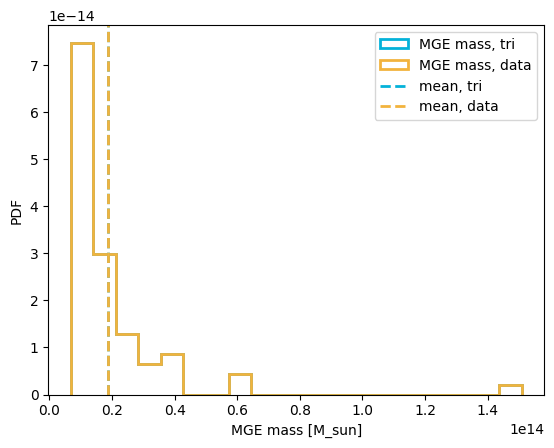

In [19]:
total_mass_tri_all = np.zeros_like(inc_tri_all)
for i in range(len(total_mass_tri_all)):
    total_mass_tri_all[i] = total_mass(peak_den[i], sigma_den_tri[i], Qobs_tri_all[i], distance)

total_mass_axi_all = np.zeros_like(inc_data)
for i in range(len(total_mass_axi_all)):
    total_mass_axi_all[i] = total_mass(peak_den[i], sigma_den[i], qobs_data[i], distance)

plt.figure()
plt.hist(total_mass_tri_all, density=True, histtype='step', lw=2, label = 'MGE mass, tri', bins=20)
plt.hist(total_mass_axi_all, density=True, histtype='step', lw=2, label = 'MGE mass, data', bins=20)
plt.axvline(np.mean(total_mass_tri_all), lw=2, ls='--', label = 'mean, tri', color=clist[0], marker = ' ')
plt.axvline(np.mean(total_mass_axi_all), lw=2, ls='--', label = 'mean, data', color=clist[1], marker = ' ')
plt.xlabel('MGE mass [M_sun]')
# plt.xscale('log')
plt.ylabel('PDF')
plt.legend()
plt.show()